# ARSG Exercises
This notebook is modified from [NLP From Scratch: Translation with a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), aiming at adding essential features and solving exercises after the tutorial.

I have added several features, including:
 - Train model with longer, more complex and more sentences.
 - Consider location(or position) information in attention mechanism.
 - Try with more layers, more hidden units. Compare the training time and results.
 - Replace the embeddings with pretrained word embeddings such as word2vec or GloVe

Features to be constructed include:
 - Build an automatic evaluation function, and evaluate the model's performance
 - Try another dataset to build an autoencoder.
 - Try another dataset to build a conversational model.


## Working Logs
- Train model with long and complex sentences.  
  - By visualization of distribution of dataset I see that actually around 90% of sentences have words less than 10. So instead of increasing the length of sentences in the dataset, I dropped the restriction of specific English prefixes. This brings a ten times of size of training dataset.
  - To address the problem of long time trianing on the large dataset, I fully utilized T4 GPU provided by Google Colab by increasing the batch size to $2^{12}$. This accelerates at least 10 times the training process and finish training in around 10min.
  - Then I increased the maximum of length of sentences in training dataset to 20. This induced lacking of GPU memory. I reduced batch size to $2^{10}$ to solve this problem. But we may try a better solution. We may use different shape of training tensors to store sentences in different range of length seperately. The training took 40min to complete using T4 GPU provided by Google Colab.
  - I implemented the idea above, using different shape of training tensors to store sentences in different range of length seperately, and seperately making dataloaders of different batch size to fully utilize T4 GPU. Then I trained the model, the encoder and the decoder, with all dataloaders. The training took 24min, 40% less than the original training strategy.
- Construct an evaluation function, evaluating the model's performance.
  - To use a BLEU score, multiple reference texts in dataset is required.
- Consider location information in attention mechanism.
  - Complete, mainly by modified BahdanauAttention class. I encoded the previous weight in the specific position by multiplying a trainable parameter and add to the sum of query and keys, i.e. $
  e_{ij}=a(s_{i-1}, \alpha_{i-1,j}, h_j)=v_a^T\tanh(W_as_{i-1}+U_ah_j+P_a\alpha_{i-1,j}).$
- Try with more layers, more hidden units, and more sentences. Compare the training time and results.
  - I constructed APIs for bidirectional model and multilayer model. Specifically, I modified encoder, decoder and BahdanauAttention. In BahdanauAttention I map the multilayer bidirectional query vector and the bidirectional keys vector to fixed size vectors. Then sum them with previous weights.  
  - The training time of bidirectional model dramatically increased to 35min. And the results of evaluation reading worse.
  - The training time of 2 layer model increase to 32min.
  - The training time of model with 2^8 hidden size increase to 31min.
- Replace the embeddings with pretrained word embeddings such as word2vec or GloVe
  - Reading papers about word2vec.
  - I replaced the trainable embedding with word2vec of Gensim. Although Gensim has several pretrained model, I trained Gensim's Word2Vec model is with French corpus in training dataset, and then used it to embed French input.
  - Training of ARSG using pretrained word2vec embedding took slightly longer time and training loss is bigger.
  


## Initialize Google Colab

In [ ]:
# Mount google drive and change working dirctory to access dataset.
from google.colab import drive
drive.mount('/content/drive')
import os
if os.getcwd() == '/content':
  os.chdir('drive/MyDrive/TorchExperiments/SequencesModel')
  print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/TorchExperiments/SequencesModel


In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
**Author**: [Sean Robertson](https://github.com/spro)

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215)_, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473)_, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  [Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation](https://arxiv.org/abs/1406.1078)_
-  [Sequence to Sequence Learning with Neural
   Networks](https://arxiv.org/abs/1409.3215)_
-  [Neural Machine Translation by Jointly Learning to Align and
   Translate](https://arxiv.org/abs/1409.0473)_
-  [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)_

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.



## Requirements

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

from gensim.test.utils import datapath
from gensim import utils
import gensim.models

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading data files

The data for this project is a set of many thousands of English to
French translation pairs.

[This question on Open Data Stack
Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)_
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repository, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   [here](https://download.pytorch.org/tutorial/data.zip)
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"([.!?])", "", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
normalizeString("J'oublie toujours les noms des gens.")

'j oublie toujours les noms des gens'

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




(array([9.5200e+02, 2.4638e+04, 4.7917e+04, 3.5527e+04, 1.6205e+04,
        6.5120e+03, 2.4800e+03, 9.8600e+02, 2.3000e+02, 2.0000e+02,
        9.4000e+01, 4.1000e+01, 2.4000e+01, 1.8000e+01, 5.0000e+00,
        3.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 1.  ,  2.88,  4.76,  6.64,  8.52, 10.4 , 12.28, 14.16, 16.04,
        17.92, 19.8 , 21.68, 23.56, 25.44, 27.32, 29.2 , 31.08, 32.96,
        34.84, 36.72, 38.6 , 40.48, 42.36, 44.24, 46.12, 48.  ]),
 <BarContainer object of 25 artists>)

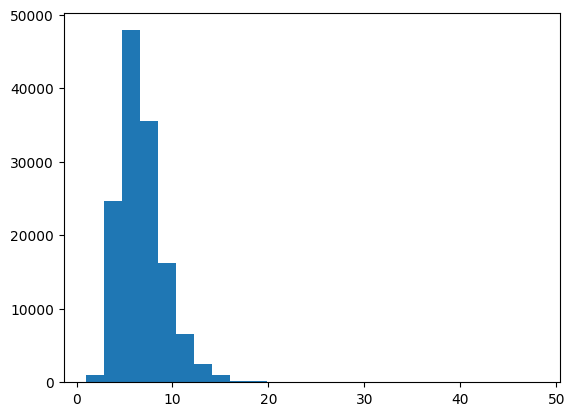

In [ ]:
lang1, lang2 = 'eng', 'fra'
lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
# See the distribution of length of sentences.
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
len_eng = [len(p[0].split(' ')) for p in pairs]
from matplotlib import pyplot as plt
plt.hist(len_eng, bins=25)

(array([642., 128.,  72.,  94.,  24.,  17.,  12.,  25.,   5.,   3.,   3.,
          2.,   1.,   0.,   4.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.]),
 array([16.  , 17.28, 18.56, 19.84, 21.12, 22.4 , 23.68, 24.96, 26.24,
        27.52, 28.8 , 30.08, 31.36, 32.64, 33.92, 35.2 , 36.48, 37.76,
        39.04, 40.32, 41.6 , 42.88, 44.16, 45.44, 46.72, 48.  ]),
 <BarContainer object of 25 artists>)

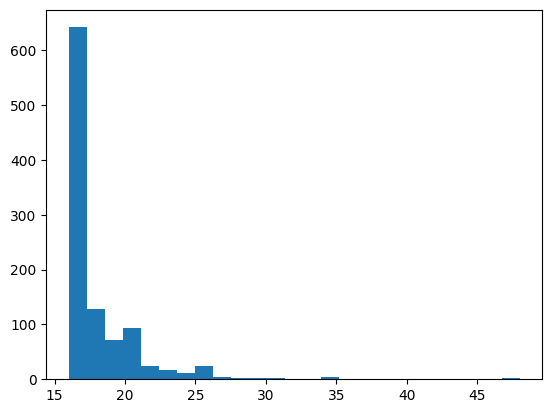

In [ ]:
len_eng = np.array(len_eng)
len_eng_15p = len_eng[len_eng > 15]
plt.hist(len_eng_15p, bins=25)
# plt.hist(len_eng, bins=25)

(array([13.,  5.,  3.,  2.,  1.,  2.,  1.,  0.,  0.,  3.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([26.  , 26.88, 27.76, 28.64, 29.52, 30.4 , 31.28, 32.16, 33.04,
        33.92, 34.8 , 35.68, 36.56, 37.44, 38.32, 39.2 , 40.08, 40.96,
        41.84, 42.72, 43.6 , 44.48, 45.36, 46.24, 47.12, 48.  ]),
 <BarContainer object of 25 artists>)

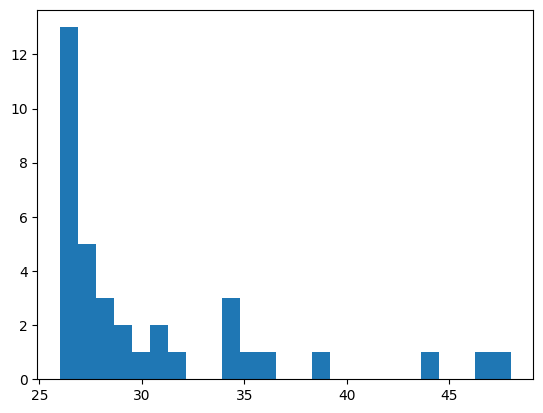

In [ ]:
len_eng = np.array(len_eng)
len_eng_25p = len_eng[len_eng > 25]
plt.hist(len_eng_25p, bins=25)

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
# Filter pairs by max and min length of sentences and English prefixes
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p, max_len, min_len, if_filt_prefix):
    return len(p[0].split(' ')) < max_len and \
        len(p[1].split(' ')) < max_len and \
        (p[1].startswith(eng_prefixes) and if_filt_prefix or \
          not if_filt_prefix) and \
        (len(p[0].split(' ')) >= min_len or \
        len(p[1].split(' ')) >= min_len)


def filterPairs(pairs, max_len, min_len, if_filt_prefix):
    return [pair for pair in pairs if filterPair(pair, max_len, min_len, if_filt_prefix)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 105692 sentence pairs
Counting words...
Counted words:
fra 17864
eng 10698
['pourquoi ne pas commander des pizzas ?', 'why don t we order pizza ?']


In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 135283 sentence pairs
Counting words...
Counted words:
fra 21170
eng 12917
['notre tour des alpes francaises a velo dura deux semaines', 'our bike tour of the french alps lasted two weeks']


In [ ]:
# Prepare data with different length range and filter sequences with English prefixes.
def prepareData(lang1, lang2, reverse=False, if_filt_prefix=True, len_split_points=[10]):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    # Count all words in dataset
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    pairs_list = []
    pre_point = 0
    for point in len_split_points:
      pairs_list.append(filterPairs(pairs, point, pre_point, if_filt_prefix))
      print("Trimmed to %s sentence pairs of length between %d and %d" % (len(pairs_list[-1]), pre_point, point))
      pre_point = point

    return input_lang, output_lang, pairs_list



In [ ]:
input_lang, output_lang, pairs_list = prepareData('eng', 'fra', True, True, [10, 20])
print(random.choice(pairs_list[-1]))

Reading lines...
Read 135380 sentence pairs
Counting words...
Counted words:
fra 21101
eng 12863
Trimmed to 11445 sentence pairs of length between 0 and 10
Trimmed to 1607 sentence pairs of length between 10 and 20
['j accroche au mur une photo de ma grand mere', 'i m hanging a picture of my grandmother on the wall']


In [ ]:
input_lang, output_lang, pairs = readLangs('eng', 'fra', True)


Reading lines...


In [ ]:
a = [pair[0][-1] in '.?!' for pair in pairs]

In [ ]:
print(sum(a), len(a), sep='/')

0/135380


In [ ]:
b = [pair[0][-1] in '.?!' for pair in pairs_list[0]]
print(sum(b), len(b), sep='/')

353/11445


In [ ]:
c = [pair[0][-1] in '.?!' for pair in pairs_list[1]]
print(sum(c), len(c), sep='/')

103/1607


## The Seq2Seq Model

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence ``Je ne suis pas le chat noir`` → ``I am not the
black cat``. Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. ``chat noir`` and ``black cat``. Because of the ``ne/pas``
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




### Word2Vec Model

#### Gensim's word2vec demo

In [ ]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)


In [ ]:
sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences)

In [ ]:
vec_king = model.wv['king']

In [ ]:
print(vec_king.shape)

(100,)


#### Gensim's word2vec model trained on dataset

In [ ]:
class CorpusfromPath:
  """Corpus of data eng-fra.txt"""
  def __init__(self, path):
    self.path = path
  def __iter__(self):
      for line in open(self.path):
          # assume there's one document per line, tokens separated by whitespace
          yield utils.simple_preprocess(line)

In [ ]:
corpus = CorpusfromPath(os.path.join('data', 'eng-fra.txt'))
vector_size = hidden_size = 2**7
workers = 1
model = gensim.models.Word2Vec(sentences=corpus, vector_size=vector_size, workers=workers)

In [ ]:
jump_vec = model.wv['jump']

In [ ]:
print(jump_vec.shape)
print(jump_vec)

(128,)
[ 0.13227919 -0.01616052  0.06998881  0.2795041  -0.2876691   0.01588585
  0.26814267  0.107416    0.2175678  -0.10342063 -0.09447497 -0.37504724
 -0.16043301 -0.43758395  0.22836854  0.14943987  0.3052172   0.06640745
  0.14325139 -0.14543456  0.11801863 -0.25853574 -0.28164187 -0.28306323
 -0.07489932 -0.1013978  -0.06457721 -0.06121218  0.16933928 -0.12537512
  0.324421   -0.12121534 -0.00479255 -0.3626915   0.16110283 -0.06264769
  0.09161223 -0.04954673  0.13171832 -0.1854432  -0.12822708  0.26891026
 -0.3647126   0.17547238  0.07562348 -0.30104446 -0.05813612 -0.10879594
 -0.3134525   0.15135805 -0.05144145 -0.0367718   0.08154546 -0.06748135
 -0.08045161  0.00264495 -0.08465866  0.0598894  -0.2952955   0.05942517
  0.04634761 -0.06677979  0.19116487  0.10062346  0.03401228 -0.1458146
 -0.00387106 -0.52553356 -0.18222322 -0.17614947 -0.10937034  0.06801738
  0.1677457   0.2167731   0.18734059 -0.17368506  0.11349725 -0.01704138
 -0.06792911  0.00745813 -0.16824082 -0.03505

#### Gensim's word2vec model trained on filtered sentence pairs list

In [ ]:
class CorpusfromPairsList:
  def __init__(self, pairs_list, tokens=[1]):
    self.pairs_list = pairs_list
    self.tokens = tokens
  def __iter__(self):
    for pairs in self.pairs_list:
      for pair in pairs:
        for take in self.tokens:
          yield utils.simple_preprocess(pair[take], min_len=1, max_len=20)

In [ ]:
corpus = CorpusfromPairsList(pairs_list, tokens=[0])
vector_size = embedding_size = 2**7
workers = 1
word2vec = gensim.models.Word2Vec(sentences=corpus, vector_size=vector_size, workers=workers)

In [ ]:
vec = word2vec.wv['merci']
print(vec.shape)
print(vec)

(128,)
[ 2.00883411e-02 -3.21791880e-02  7.18929842e-02 -6.99628028e-04
  2.01362092e-03 -1.71464533e-02  1.57174375e-02 -6.85400842e-03
  2.05560066e-02  2.15606391e-03  1.08098544e-01  7.28501985e-03
 -1.98693816e-02 -5.14457673e-02  7.84033686e-02  1.20887011e-02
  1.83637850e-02  8.95479508e-03 -3.15160453e-02 -6.84962841e-03
  3.50402519e-02  6.12912290e-02 -2.85655297e-02 -6.20076023e-02
 -7.36599490e-02  4.49329428e-03 -7.41976574e-02 -9.26210196e-05
  2.67393943e-02 -1.36132659e-02 -5.85762709e-02  3.10410745e-02
 -3.29278479e-03  3.36479843e-02 -1.96991116e-02  3.46627608e-02
  1.63713366e-01  3.38017456e-02  6.60938472e-02 -2.45144647e-02
  2.29416210e-02  4.79789935e-02  6.61722897e-03 -4.16056700e-02
  3.74645293e-02 -1.97785292e-02 -6.51470348e-02 -5.60288951e-02
  2.05490384e-02 -3.02178459e-03  6.72079474e-02 -8.67674593e-03
  2.56021153e-02  3.09973452e-02  2.88784243e-02  2.27073263e-02
  8.84414539e-02  2.65249964e-02 -6.53505474e-02 -1.85769368e-02
 -6.00793958e-03 -

### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
# Multilayer bidirectional GRU encoder.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1, num_layers=1, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
# Multilayer bidirectional GRU encoder based on word2vec embedding.
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, dropout_p=0.1, num_layers=1, bidirectional=False):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # embedded = self.dropout(self.embedding(input))
        embedded = self.dropout(input)
        output, hidden = self.gru(embedded)
        return output, hidden

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




#### Attention Decoder

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:


Bahdanau attention, also known as additive attention, is a commonly used
attention mechanism in sequence-to-sequence models, particularly in neural
machine translation tasks. It was introduced by Bahdanau et al. in their
paper titled [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf)_.
This attention mechanism employs a learned alignment model to compute attention
scores between the encoder and decoder hidden states. It utilizes a feed-forward
neural network to calculate alignment scores.

However, there are alternative attention mechanisms available, such as Luong attention,
which computes attention scores by taking the dot product between the decoder hidden
state and the encoder hidden states. It does not involve the non-linear transformation
used in Bahdanau attention.

In this tutorial, we will be using Bahdanau attention. However, it would be a valuable
exercise to explore modifying the attention mechanism to use Luong attention.



In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

        self.Pa = nn.Linear(1, 1) # encode pre weight in only 1 location j that stores location information

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # sample, layer, dim; sample, location, dim; broadcastable because layer equals 1 here; 2h^2 weight params, 2h weight params enough however
        scores = scores.squeeze(2).unsqueeze(1)
        # sample, size1, location

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        # sample, size1, dim

        return context, weights

In [ ]:
# Consider location information
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

        self.Pa = nn.Linear(1, 1) # encode pre weight in only 1 location j that stores location information

    def forward(self, query, keys, preweights):
        # scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # # sample, layer, dim; sample, location, dim; broadcastable because layer equals 1 here; 2h^2 weight params, 2h weight params enough however
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys) + self.Pa(preweights.permute(0,2,1))))
        # sample, layer, dim; sample, location, dim; sample, location, size1;
        scores = scores.squeeze(2).unsqueeze(1)
        # sample, size1, location

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        # sample, size1, dim

        return context, weights


In [ ]:
# Consider location information.
# Process multilayer hidden state.
# Process bi-directional GRU
class BahdanauAttention(nn.Module):
    # def __init__(self, hidden_size):
    def __init__(self, hidden_size, num_layers, bidirectional=False):
        super(BahdanauAttention, self).__init__()
        D = 2 if bidirectional else 1
        self.Wa = nn.Linear(hidden_size * num_layers * D, hidden_size)
        self.Ua = nn.Linear(hidden_size * D, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

        self.Pa = nn.Linear(1, 1) # encode pre weight in only 1 location j that stores location information


    def forward(self, query, keys, pre_weights):
        # scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # # sample, layer, dim; sample, location, dim; broadcastable because layer equals 1 here; 2h^2 weight params, 2h weight params enough however

        # scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys) + self.Pa(pre_weights.permute(0,2,1))))
        # # sample, layer*D, dim; sample, location, D*dim; sample, location, size1;

        scores = self.Va(torch.tanh(self.Wa(torch.flatten(query, 1).unsqueeze(1)) + self.Ua(keys) + self.Pa(pre_weights.permute(0,2,1))))
        # sample, 1, layer*D*dim; sample, location, D*dim; sample, location, 1;
        scores = scores.squeeze(2).unsqueeze(1)
        # sample, size1, location

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        # sample, size1, dim

        return context, weights

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
# Adapt for sequence length
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    # def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    def forward(self, encoder_outputs, encoder_hidden, max_len, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        # for i in range(MAX_LENGTH):
        for i in range(max_len):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
# Encode pre-weights
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    # def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    def forward(self, encoder_outputs, encoder_hidden, max_len, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        attn_weights = torch.zeros(batch_size, 1, max_len, device=device)
        decoder_outputs = []
        attentions = []

        # for i in range(MAX_LENGTH):
        for i in range(max_len):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                # decoder_input, decoder_hidden, encoder_outputs
                decoder_input, decoder_hidden, encoder_outputs, attn_weights
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs, pre_weights):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        # context, attn_weights = self.attention(query, encoder_outputs)
        context, attn_weights = self.attention(query, encoder_outputs, pre_weights)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [ ]:
# Decoder using Multilayer bidirectional GRU.
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, dropout_p=0.1, bidirectional=False):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size, num_layers, bidirectional=bidirectional)
        D = 2 if bidirectional else 1
        self.gru = nn.GRU((D+1) * hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.out = nn.Linear(hidden_size*D, output_size)
        self.dropout = nn.Dropout(dropout_p)

    # def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
    def forward(self, encoder_outputs, encoder_hidden, max_len, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        attn_weights = torch.zeros(batch_size, 1, max_len, device=device)
        decoder_outputs = []
        attentions = []

        # for i in range(MAX_LENGTH):
        for i in range(max_len):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                # decoder_input, decoder_hidden, encoder_outputs
                decoder_input, decoder_hidden, encoder_outputs, attn_weights
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs, pre_weights):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        # context, attn_weights = self.attention(query, encoder_outputs)
        context, attn_weights = self.attention(query, encoder_outputs, pre_weights)
        input_gru = torch.cat((embedded, context), dim=2)

        # print(f'input_gru.shape={input_gru.shape}, hidden.shape={hidden.shape}')
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in [Effective Approaches to Attention-based Neural Machine
  Translation](https://arxiv.org/abs/1508.04025)_.</p></div>

## Training






### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [ ]:
def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
# Prepare dataloaders for sequences of different length.
def get_dataloader_list(batch_size_list, len_split_points, filt_prefix=True):
    input_lang, output_lang, pairs_list = prepareData('eng', 'fra', True, filt_prefix, len_split_points)
    dataloader_list = [get_dataloader(batch_size_list[idx], pairs_list[idx], len_split_points[idx]) for idx in range(len(len_split_points))]
    return input_lang, output_lang, dataloader_list


def get_dataloader(batch_size, pairs, max_len):
    # input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, max_len), dtype=np.int32)
    target_ids = np.zeros((n, max_len), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # return input_lang, output_lang, train_dataloader
    return train_dataloader

In [ ]:
def vecs_from_sentence(word2vec_emb, sentence):
  return np.array([word2vec_emb.wv[word] for word in sentence.split(' ')])

In [ ]:
# Prepare dataloaders for sequences of different length.
# def get_dataloader_list(batch_size_list, len_split_points, word2vec_emb, filt_prefix=True):
def get_dataloader_list(batch_size_list, len_split_points, word2vec_emb, input_lang, output_lang, pairs_list):
    # input_lang, output_lang, pairs_list = prepareData('eng', 'fra', True, filt_prefix, len_split_points)
    dataloader_list = [get_dataloader(batch_size_list[idx], pairs_list[idx], len_split_points[idx], word2vec_emb) for idx in range(len(len_split_points))]
    return dataloader_list

# Utilize trained word2vec embedding to embed input.
def get_dataloader(batch_size, pairs, max_len, word2vec_emb):
    # input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    # input_ids = np.zeros((n, max_len), dtype=np.int32)
    input_vecs = np.zeros((n, max_len, word2vec_emb.vector_size))
    target_ids = np.zeros((n, max_len), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        # inp_ids = indexesFromSentence(input_lang, inp)
        inp_vecs = vecs_from_sentence(word2vec_emb, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        # inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        # input_ids[idx, :len(inp_ids)] = inp_ids
        input_vecs[idx, :len(inp_vecs), :] = inp_vecs
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
    #                            torch.LongTensor(target_ids).to(device))
    train_data = TensorDataset(torch.Tensor(input_vecs).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    # return input_lang, output_lang, train_dataloader
    return train_dataloader

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf)_.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        max_len = input_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# Training process per epoch for different sequences of length.
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        max_len = input_tensor.size(1)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, max_len, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        max_len = input_tensor.size(1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, max_len)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
# Evaluate input sentence using word2vec embedding
# def evaluate(encoder, decoder, sentence, input_lang, output_lang):
def evaluate(encoder, decoder, sentence, word2vec_emb, output_lang):
    with torch.no_grad():
        # input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = torch.tensor(vecs_from_sentence(word2vec_emb, sentence), device=device).unsqueeze(0)
        max_len = input_tensor.size(1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden, max_len)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
# Evaluate input sentence using word2vec embedding
def evaluateRandomly(encoder, decoder, pairs, word2vec_emb, output_lang, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], word2vec_emb, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating



### Training

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 37s (- 9m 29s) (5 6%) 1.5377
1m 14s (- 8m 38s) (10 12%) 0.6889
1m 49s (- 7m 54s) (15 18%) 0.3561
2m 24s (- 7m 14s) (20 25%) 0.1976
2m 59s (- 6m 34s) (25 31%) 0.1227
3m 34s (- 5m 57s) (30 37%) 0.0846
4m 9s (- 5m 20s) (35 43%) 0.0648
4m 43s (- 4m 43s) (40 50%) 0.0527
5m 19s (- 4m 8s) (45 56%) 0.0455
5m 53s (- 3m 32s) (50 62%) 0.0410
6m 28s (- 2m 56s) (55 68%) 0.0378
7m 2s (- 2m 20s) (60 75%) 0.0348
7m 37s (- 1m 45s) (65 81%) 0.0331
8m 13s (- 1m 10s) (70 87%) 0.0317
8m 47s (- 0m 35s) (75 93%) 0.0310
9m 22s (- 0m 0s) (80 100%) 0.0293


In [ ]:
# Increase batch size to accelerate.
hidden_size = 128
batch_size = 256

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 4s (- 1m 7s) (5 6%) 2.6081
0m 9s (- 1m 4s) (10 12%) 1.5640
0m 14s (- 1m 3s) (15 18%) 1.1890
0m 19s (- 0m 57s) (20 25%) 0.9213
0m 24s (- 0m 52s) (25 31%) 0.7166
0m 29s (- 0m 48s) (30 37%) 0.5585
0m 33s (- 0m 43s) (35 43%) 0.4366
0m 38s (- 0m 38s) (40 50%) 0.3424
0m 43s (- 0m 33s) (45 56%) 0.2711
0m 47s (- 0m 28s) (50 62%) 0.2168
0m 53s (- 0m 24s) (55 68%) 0.1754
0m 57s (- 0m 19s) (60 75%) 0.1442
1m 2s (- 0m 14s) (65 81%) 0.1205
1m 7s (- 0m 9s) (70 87%) 0.1015
1m 12s (- 0m 4s) (75 93%) 0.0875
1m 16s (- 0m 0s) (80 100%) 0.0755


In [ ]:
# Increase batch size to accelerate.
hidden_size = 128
batch_size = 2**11

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 3s (- 0m 52s) (5 6%) 4.8661
0m 6s (- 0m 48s) (10 12%) 2.7447
0m 10s (- 0m 44s) (15 18%) 2.3956
0m 13s (- 0m 40s) (20 25%) 2.2065
0m 17s (- 0m 37s) (25 31%) 2.0450
0m 20s (- 0m 34s) (30 37%) 1.8948
0m 23s (- 0m 30s) (35 43%) 1.7607
0m 27s (- 0m 27s) (40 50%) 1.6424
0m 30s (- 0m 24s) (45 56%) 1.5382
0m 34s (- 0m 20s) (50 62%) 1.4463
0m 37s (- 0m 17s) (55 68%) 1.3623
0m 41s (- 0m 13s) (60 75%) 1.2836
0m 44s (- 0m 10s) (65 81%) 1.2094
0m 48s (- 0m 6s) (70 87%) 1.1388
0m 51s (- 0m 3s) (75 93%) 1.0715
0m 55s (- 0m 0s) (80 100%) 1.0078


In [ ]:
# Increase batch size to accelerate and remove the filter of English prefixes.
hidden_size = 128
batch_size = 2**12

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 105692 sentence pairs
Counting words...
Counted words:
fra 17864
eng 10698
0m 49s (- 12m 15s) (5 6%) 4.1717
1m 42s (- 11m 56s) (10 12%) 2.9332
2m 32s (- 11m 0s) (15 18%) 2.4736
3m 23s (- 10m 11s) (20 25%) 2.1223
4m 14s (- 9m 20s) (25 31%) 1.8146
5m 7s (- 8m 32s) (30 37%) 1.5595
5m 58s (- 7m 40s) (35 43%) 1.3510
6m 50s (- 6m 50s) (40 50%) 1.1832
7m 40s (- 5m 58s) (45 56%) 1.0486
8m 32s (- 5m 7s) (50 62%) 0.9414
9m 23s (- 4m 16s) (55 68%) 0.8546
10m 15s (- 3m 25s) (60 75%) 0.7828
11m 6s (- 2m 33s) (65 81%) 0.7224
11m 57s (- 1m 42s) (70 87%) 0.6721
12m 49s (- 0m 51s) (75 93%) 0.6276
13m 40s (- 0m 0s) (80 100%) 0.5899


In [ ]:
# Remove the filter of English prefixes and decrease batch size to
# adapt for increasing sequence length. 40 min
hidden_size = 128
batch_size = 2**10

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 135283 sentence pairs
Counting words...
Counted words:
fra 21170
eng 12917
2m 35s (- 38m 45s) (5 6%) 1.8750
5m 9s (- 36m 3s) (10 12%) 1.1693
7m 43s (- 33m 26s) (15 18%) 0.8421
10m 17s (- 30m 52s) (20 25%) 0.6436
12m 51s (- 28m 16s) (25 31%) 0.5271
15m 24s (- 25m 40s) (30 37%) 0.4503
17m 57s (- 23m 4s) (35 43%) 0.3955
20m 30s (- 20m 30s) (40 50%) 0.3551
23m 3s (- 17m 55s) (45 56%) 0.3236
25m 36s (- 15m 21s) (50 62%) 0.2983
28m 9s (- 12m 47s) (55 68%) 0.2774
30m 42s (- 10m 14s) (60 75%) 0.2592
33m 15s (- 7m 40s) (65 81%) 0.2439
35m 48s (- 5m 6s) (70 87%) 0.2304
38m 21s (- 2m 33s) (75 93%) 0.2187
40m 54s (- 0m 0s) (80 100%) 0.2079


In [ ]:
# Remove the filter of English prefixes and train with different batch
# size adapt for sentences of different length to accelerate. 24min
hidden_size = 128
batch_size_list = [2**11, 2**10]
len_split_points = [10, 20]

input_lang, output_lang, train_dataloader_list = get_dataloader_list(batch_size_list, len_split_points, False)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

for train_dataloader in train_dataloader_list:
  train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=20)

Reading lines...
Read 135842 sentence pairs
Counting words...
Counted words:
fra 21327
eng 13035
Trimmed to 105692 sentence pairs of length between 0 and 10
Trimmed to 29591 sentence pairs of length between 10 and 20
0m 56s (- 14m 10s) (5 6%) 3.6314
1m 52s (- 13m 6s) (10 12%) 2.4650
2m 48s (- 12m 9s) (15 18%) 1.8960
3m 44s (- 11m 12s) (20 25%) 1.4977
4m 40s (- 10m 16s) (25 31%) 1.2207
5m 36s (- 9m 20s) (30 37%) 1.0240
6m 32s (- 8m 24s) (35 43%) 0.8819
7m 29s (- 7m 29s) (40 50%) 0.7750
8m 26s (- 6m 34s) (45 56%) 0.6922
9m 22s (- 5m 37s) (50 62%) 0.6265
10m 18s (- 4m 41s) (55 68%) 0.5733
11m 15s (- 3m 45s) (60 75%) 0.5286
12m 11s (- 2m 48s) (65 81%) 0.4915
13m 8s (- 1m 52s) (70 87%) 0.4595
14m 4s (- 0m 56s) (75 93%) 0.4319
15m 2s (- 0m 0s) (80 100%) 0.4074
0m 34s (- 8m 35s) (5 6%) 1.2168
1m 8s (- 8m 2s) (10 12%) 0.9445
1m 43s (- 7m 27s) (15 18%) 0.8103
2m 17s (- 6m 53s) (20 25%) 0.7144
2m 51s (- 6m 18s) (25 31%) 0.6400
3m 26s (- 5m 43s) (30 37%) 0.5778
4m 0s (- 5m 9s) (35 43%) 0.5268
4m 

In [ ]:
# An experiment, actually being same as v4. 41min
hidden_size = 128
batch_size_list = [2**10]
len_split_points = [20]

input_lang, output_lang, train_dataloader_list = get_dataloader_list(batch_size_list, len_split_points, False)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

for train_dataloader in train_dataloader_list:
  train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=20)

Reading lines...
Read 135842 sentence pairs
Counting words...
Counted words:
fra 21327
eng 13035
Trimmed to 135283 sentence pairs of length between 0 and 20
2m 35s (- 38m 57s) (5 6%) 1.9052
5m 9s (- 36m 5s) (10 12%) 1.3048
7m 44s (- 33m 34s) (15 18%) 1.0259
10m 19s (- 30m 57s) (20 25%) 0.7788
12m 55s (- 28m 25s) (25 31%) 0.6097
15m 29s (- 25m 49s) (30 37%) 0.5040
18m 5s (- 23m 15s) (35 43%) 0.4326
20m 39s (- 20m 39s) (40 50%) 0.3816
23m 15s (- 18m 5s) (45 56%) 0.3432
25m 50s (- 15m 30s) (50 62%) 0.3126
28m 25s (- 12m 55s) (55 68%) 0.2882
31m 1s (- 10m 20s) (60 75%) 0.2682
33m 35s (- 7m 45s) (65 81%) 0.2511
36m 11s (- 5m 10s) (70 87%) 0.2359
38m 46s (- 2m 35s) (75 93%) 0.2234
41m 22s (- 0m 0s) (80 100%) 0.2119


In [ ]:
# Remove the filter of English prefixes and train with different batch
# size adapt for sentences of different length to accelerate.
# Consider position information, that is the pre_weights.
hidden_size = 128
batch_size_list = [2**12, 2**11]
len_split_points = [10, 20]

input_lang, output_lang, train_dataloader_list = get_dataloader_list(batch_size_list, len_split_points, False)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

for train_dataloader in train_dataloader_list:
  train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=20)

Reading lines...
Read 135842 sentence pairs
Counting words...
Counted words:
fra 21327
eng 13035
Trimmed to 105692 sentence pairs of length between 0 and 10
Trimmed to 29591 sentence pairs of length between 10 and 20
0m 53s (- 13m 25s) (5 6%) 4.2646
1m 47s (- 12m 29s) (10 12%) 3.0554
2m 40s (- 11m 36s) (15 18%) 2.5987
3m 34s (- 10m 42s) (20 25%) 2.2594
4m 27s (- 9m 48s) (25 31%) 1.9488
5m 21s (- 8m 55s) (30 37%) 1.6824
6m 14s (- 8m 1s) (35 43%) 1.4606
7m 8s (- 7m 8s) (40 50%) 1.2779
8m 2s (- 6m 15s) (45 56%) 1.1300
8m 55s (- 5m 21s) (50 62%) 1.0110
9m 49s (- 4m 27s) (55 68%) 0.9147
10m 43s (- 3m 34s) (60 75%) 0.8347
11m 36s (- 2m 40s) (65 81%) 0.7689
12m 31s (- 1m 47s) (70 87%) 0.7124
13m 26s (- 0m 53s) (75 93%) 0.6640
14m 20s (- 0m 0s) (80 100%) 0.6221
0m 30s (- 7m 42s) (5 6%) 1.3097
1m 1s (- 7m 11s) (10 12%) 1.0844
1m 32s (- 6m 40s) (15 18%) 0.9712
2m 3s (- 6m 10s) (20 25%) 0.8840
2m 34s (- 5m 39s) (25 31%) 0.8137
3m 5s (- 5m 8s) (30 37%) 0.7539
3m 35s (- 4m 37s) (35 43%) 0.7025
4m 6

In [ ]:
# Remove the filter of English prefixes and train with different batch
# size adapt for sentences of different length to accelerate.
# Consider position information, that is the pre_weights.
# Multilayer bidirectional model with more hidden units.
hidden_size = 2**8
batch_size_list = [2**12, 2**11]
len_split_points = [10, 20]
filter_prefix = False
num_layers = 1
bidirectional = False
num_epochs = 80

input_lang, output_lang, train_dataloader_list = get_dataloader_list(batch_size_list, len_split_points, filter_prefix)

encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers=num_layers, bidirectional=bidirectional).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, num_layers=num_layers, bidirectional=bidirectional).to(device)

for train_dataloader in train_dataloader_list:
  train(train_dataloader, encoder, decoder, num_epochs, print_every=5, plot_every=20)

Reading lines...
Read 135842 sentence pairs
Counting words...
Counted words:
fra 21327
eng 13035
Trimmed to 105692 sentence pairs of length between 0 and 10
Trimmed to 29591 sentence pairs of length between 10 and 20
1m 10s (- 17m 43s) (5 6%) 3.5568
2m 21s (- 16m 31s) (10 12%) 2.3605
3m 31s (- 15m 17s) (15 18%) 1.7714
4m 42s (- 14m 7s) (20 25%) 1.3301
5m 52s (- 12m 54s) (25 31%) 1.0230
7m 2s (- 11m 44s) (30 37%) 0.8152
8m 13s (- 10m 33s) (35 43%) 0.6698
9m 23s (- 9m 23s) (40 50%) 0.5642
10m 33s (- 8m 13s) (45 56%) 0.4853
11m 44s (- 7m 2s) (50 62%) 0.4238
12m 55s (- 5m 52s) (55 68%) 0.3754
14m 6s (- 4m 42s) (60 75%) 0.3363
15m 16s (- 3m 31s) (65 81%) 0.3033
16m 27s (- 2m 21s) (70 87%) 0.2756
17m 38s (- 1m 10s) (75 93%) 0.2516
18m 48s (- 0m 0s) (80 100%) 0.2309
0m 44s (- 11m 9s) (5 6%) 1.1653
2m 14s (- 9m 41s) (15 18%) 0.6353
2m 58s (- 8m 56s) (20 25%) 0.5210
3m 43s (- 8m 11s) (25 31%) 0.4349
4m 28s (- 7m 27s) (30 37%) 0.3705
5m 13s (- 6m 42s) (35 43%) 0.3182
5m 57s (- 5m 57s) (40 50%) 0

In [ ]:
# Remove the filter of English prefixes and train with different batch
# size adapt for sentences of different length to accelerate.
# Consider position information, that is the pre_weights.
# Multilayer bidirectional model with more hidden units.
# Experiment word2vec embedding.
hidden_size = 2**8
batch_size_list = [2**12, 2**11]
len_split_points = [10, 20]
filter_prefix = False
w2v_min_count = 0
w2v_workers = 1
num_layers = 1
bidirectional = False
num_epochs = 80

In [ ]:
input_lang, output_lang, pairs_list = prepareData('eng', 'fra', True, filter_prefix, len_split_points)


Reading lines...
Read 135380 sentence pairs
Counting words...
Counted words:
fra 21101
eng 12862
Trimmed to 107809 sentence pairs of length between 0 and 10
Trimmed to 27352 sentence pairs of length between 10 and 20


In [ ]:
corpus = CorpusfromPairsList(pairs_list, tokens=[0])
word2vec = gensim.models.Word2Vec(sentences=corpus, min_count=w2v_min_count, vector_size=hidden_size, workers=w2v_workers)


In [ ]:
train_dataloader_list = get_dataloader_list(batch_size_list, len_split_points, word2vec, input_lang, output_lang, pairs_list)

In [ ]:
# encoder = EncoderRNN(input_lang.n_words, hidden_size, num_layers=num_layers, bidirectional=bidirectional).to(device)
encoder = EncoderRNN(hidden_size, num_layers=num_layers, bidirectional=bidirectional).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, num_layers=num_layers, bidirectional=bidirectional).to(device)


In [ ]:
for train_dataloader in train_dataloader_list:
  train(train_dataloader, encoder, decoder, num_epochs, print_every=5, plot_every=20)

1m 8s (- 17m 13s) (5 6%) 2.1194
2m 19s (- 16m 15s) (10 12%) 1.4036
3m 29s (- 15m 8s) (15 18%) 1.0666
4m 40s (- 14m 1s) (20 25%) 0.8679
5m 51s (- 12m 54s) (25 31%) 0.7340
7m 3s (- 11m 46s) (30 37%) 0.6372
8m 15s (- 10m 36s) (35 43%) 0.5628
9m 27s (- 9m 27s) (40 50%) 0.5036
10m 38s (- 8m 16s) (45 56%) 0.4555
11m 50s (- 7m 6s) (50 62%) 0.4154
13m 2s (- 5m 55s) (55 68%) 0.3814
14m 14s (- 4m 44s) (60 75%) 0.3525
15m 26s (- 3m 33s) (65 81%) 0.3268
16m 38s (- 2m 22s) (70 87%) 0.3050
17m 50s (- 1m 11s) (75 93%) 0.2854
19m 2s (- 0m 0s) (80 100%) 0.2676
0m 41s (- 10m 19s) (5 6%) 1.4064
1m 22s (- 9m 37s) (10 12%) 0.9727
2m 3s (- 8m 56s) (15 18%) 0.7755
2m 45s (- 8m 15s) (20 25%) 0.6445
3m 26s (- 7m 34s) (25 31%) 0.5498
4m 7s (- 6m 52s) (30 37%) 0.4764
4m 48s (- 6m 11s) (35 43%) 0.4206
5m 30s (- 5m 30s) (40 50%) 0.3742
6m 11s (- 4m 48s) (45 56%) 0.3370
6m 52s (- 4m 7s) (50 62%) 0.3041
7m 33s (- 3m 26s) (55 68%) 0.2748
8m 15s (- 2m 45s) (60 75%) 0.2509
8m 56s (- 2m 3s) (65 81%) 0.2291
9m 37s (- 1m 

### Evaluating

Set dropout layers to ``eval`` mode



In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs)

In [ ]:
# Evaluate model, that trained with sentences of len10 and len20, with sentences of len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> je ne vais le dire qu une seule fois alors vous feriez mieux d ecouter
= i m only going to say this once so you better listen
< i m only going to tell the only one time you d better listen <EOS>

> je suis vraiment desole pour ce que j ai dit
= i am very sorry for what i said
< i really am sorry for what i said said <EOS>

> je suis aussi fatigue que l on peut l etre
= i m as tired as tired can be
< i m as tired as the can can be so we

> j irai au japon avec ma copine en aout
= i m going to japan with my girlfriend in august
< i will go to japan with my girlfriend in august

> je me rejouis que les choses se soient passees aussi bien
= i m glad things went so well
< i m glad things went so well as well <EOS>

> je vous demande de le faire parce que j ai confiance en vous
= i m asking you to do this because i trust you
< i m asking you to do this because i trust you <EOS>

> je commence a sentir que quelque chose ne va pas
= i m beginning to smell a rat
< i m feeling something that s

In [ ]:
# Evaluate model, that trained with sentences of len20, with sentences of len10 and len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> je ne suis pas certain de ce qu il pensait
= i m not sure what he was thinking
< i m not sure what he thought i was thinking <EOS>

> elle a pris sa decision et refuse d en etre dissuadee
= she s made up her mind and refuses to be talked out of it
< she has made her decision and refuses to be used to but

> je suis desole d avoir ete dans l incapacite d etre la pour toi
= i m sorry that i haven t been able to be here for you
< i m sorry to be able to be here for the being you re doing

> tu n es pas le seul a ressentir cela
= you re not the only one who feels that way
< you aren t alone who owns that difficult <EOS>

> je suis prete a vous aider si vous voulez que je le fasse
= i m willing to help you if you want me to
< i m willing to help you if you want me to me to <EOS>

> je ne suis pas bon pour faire plusieurs taches en meme temps
= i m not good at multitasking
< i m not good at multitasking <EOS>

> c est un chic type sauf qu il parle trop
= he is a nice man except that he tal

In [ ]:
# Evaluate model, that consider position information and trained with
# sentences of len10 and len20, with sentences of len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> il n est pas trop pauvre pour acheter une bicyclette
= he is not too poor to buy a bicycle
< it s not too poor to buy a bicycle to buy

> je suis desole pour la douleur que je vous ai causee a vous et a votre famille
= i m sorry for the pain i caused you and your family
< i m sorry for the pain i caused you and your family <EOS>

> je me fais beaucoup de souci au sujet de ta sante
= i m very worried about your health
< i worry about a lot of your health <EOS>

> je suis desole de t ennuyer mais nous avons un petit probleme
= i m sorry to bother you but we ve got a small problem
< i m sorry to bother you but we have a small problem <EOS>

> nous sommes dans la meme equipe n est ce pas ?
= we re on the same team right ?
< we re in the same team right ? <EOS>

> tu n es pas la seule a avoir ete blessee
= you re not the only one that was hurt
< you re not the only one who was hurt you <EOS>

> elle n est pas chez elle mais a l ecole
= she is not home but at school
< she is not at home sh

In [ ]:
# Evaluate a bidirectional model, that consider position information
# and trained with sentences of len10 and len20, with sentences of len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> je vais courir voulez vous venir ?
= i m going for a run do you want to come ?
< i am going to go out so much

> elles ne sont pas tres differentes de qui que ce soit d autre
= they are not very different from anybody else
< they aren t very different from that much of anybody else <EOS>

> tu es assez grand pour t occuper de toi meme
= you are old enough to take care of yourself
< you are old enough to make up to you taking care

> je suis presque sur que je vais avoir besoin d aide
= i m pretty sure i m going to need some help
< i m pretty sure i m going to need i need some

> elle n est pas moins belle que sa s ur
= she is no less beautiful than her sister is
< she isn t less beautiful than her sister than her sister

> je cherche mon portefeuille l avez vous vu ?
= i m looking for my wallet have you seen it ?
< i m looking for my wallet for my wallet have

> je cherche l emplacement ideal pour accrocher cette photo
= i m looking for the perfect spot to hang this picture
< i m loo

In [ ]:
# Evaluate a 2 layer model, that consider position information
# and trained with sentences of len10 and len20, with sentences of len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> tu ne vas jamais croire ce qui est arrive aujourd hui
= you re never going to believe what happened today
< you ll never believe what happened to today today <EOS>

> je suis plutot sure que je n ai pas dit ca
= i m pretty sure i didn t say that
< i m pretty sure i didn t tell that <EOS>

> je recois une allocation mensuelle de cinquante mille yens
= i am given a monthly allowance of fifty thousand yen
< i m given a call of making yen yen yen

> je suis desolee que les choses n aient pas fonctionne
= i m sorry things didn t work out
< i m sorry things didn t work until <EOS>

> vous etes les etudiants de tom n est ce pas ?
= you re tom s students right ?
< you re tom s students of tom aren t you ? <EOS>

> je suis content que tu n aies pas appele tom
= i m glad you didn t call tom
< i m glad you didn t call tom tom <EOS>

> nous n avons pas de chance une fois de plus
= we re out of luck again
< we don t have a chance of more than it is

> j ai peur qu elle n accepte pas mon explicati

In [ ]:
# Evaluate a 2^8 hidden size model, that consider position information
# and trained with sentences of len10 and len20, with sentences of len20.
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1])

> je suis sur que tom a fait ce qu il a dit
= i m pretty sure tom did what he said he did
< i m sure tom did tom do what he said he said <EOS>

> je cherche l emplacement ideal pour accrocher cette photo
= i m looking for the perfect spot to hang this picture
< i m looking for the perfect spot to hang this

> il est extremement pessimiste et n a pas d ambitions
= he is extremely pessimistic and has no aspirations
< he is extremely pessimistic and has no aspirations didn t have

> tu es la derniere personne que je m attendais a voir ici
= you are the last person i would have expected to see here
< you re the last person i expected to see here here <EOS>

> tu es la femme la plus belle au monde
= you re the most beautiful woman in the whole world
< you re the most beautiful woman in the whole world

> nous sommes occupes a preparer notre mariage et notre lune de miel
= we are busy preparing for our wedding and honeymoon
< we are busy preparing for our wedding and honeymoon <EOS>

> elle 

In [ ]:
# Evaluate a 2^8 hidden size model, that consider position information
# and trained with sentences of len10 and len20, with sentences of len20.
# Evaluate word2vec embedding
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, pairs_list[1], word2vec, output_lang)

> je regarde la television tout au long de la journee
= i watch television all day long
< i watched television all day long i m working all

> j attends toujours mon petit dejeuner veuillez me l apporter maintenant
= i m still waiting for my breakfast bring it to me now please
< i m still about my breakfast i ll help him now

> je n avais pas l intention d interrompre ta conversation
= i didn t mean to interrupt your conversation
< i didn t mean to interrupt your conversation <EOS>

> il essaya de se conduire le plus bravement possible tandis qu il etait pris en otage
= he tried to behave as bravely as possible while he was being held hostage
< he tried to behave as bravely as possible while he was being held hostage <EOS>

> ce n est pas tache facile de le suivre
= it s no easy task to keep up with him
< it s easy easy to keep it up smoking

> j ai le sentiment que vous serez un tres bon avocat
= i have a feeling you ll be a very good lawyer
< i have the feeling you ll be a very good 

### Visualizing Attention

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix. For a better viewing experience we will do the
extra work of adding axes and labels:




In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>
input = je suis trop fatigue pour conduire
output = i am too tired to drive <EOS>
input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>
input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


<ipython-input-22-332b9c61fc98>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-22-332b9c61fc98>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


## Exercises

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pretrained word embeddings such as ``word2vec`` or
   ``GloVe``
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


